In [1]:
# MFMC Demo for DEAP Dataset - Tri-modal Emotion Recognition
# Multi-modal Feature Matching and Correlation (MFMC) approach
# Modalities: EEG, EOG, Temperature signals

import os
import time
from datetime import timedelta

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("MFMC Demo for DEAP Dataset")
print("=" * 50)

MFMC Demo for DEAP Dataset


In [ ]:
# =============================================================================
# EXPERIMENT CONFIGURATION
# =============================================================================

# Define base paths
BASE_PATH = '/ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP'
DATA_DIR = f'{BASE_PATH}/Data_processed'
RESULTS_DIR = f'{BASE_PATH}/MFMC_Demo/results'

# Training parameters
BATCH_SIZE = 200
TOTAL_ITERATIONS = 15001  # 15001 for test, 20001 for full training
EVAL_INTERVAL = 500       # Evaluate every 500 iterations

# Cross-validation parameters
N_FOLDS = 5              # Number of cross-validation folds
RANDOM_SEED = 42         # For reproducible results

# Optimizer parameters
LEARNING_RATE_ENCODER = 0.0003
LEARNING_RATE_CLASSIFIER = 0.0003
BETA1 = 0.9
BETA2 = 0.999

# MFMC parameters
COV_BETA = 0.5           # Exponential moving average coefficient for covariance tracking

# Data preprocessing parameters
USE_CLASS_BALANCING = False        # Class-weighted loss for imbalanced data

print("Configuration loaded successfully!")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Total iterations: {TOTAL_ITERATIONS}")
print(f"Batch size: {BATCH_SIZE}")

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)


Configuration loaded successfully!
Data directory: /ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP/Data_processed
Results directory: /ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP/MFMC_Demo/results
Total iterations: 15001
Batch size: 200


In [3]:
# =============================================================================
# MFMC LOSS FUNCTIONS AND PROJECTION HEAD
# =============================================================================

def adaptive_estimation(v_t, beta, square_term, i):
    """
    Adaptive smoothing filter for estimating covariances
    
    Args:
        v_t: Previous covariance estimate
        beta: Exponential moving average coefficient
        square_term: Current covariance matrix
        i: Current iteration number
    
    Returns:
        Updated covariance estimate and bias-corrected estimate
    """
    v_t = beta * v_t + (1 - beta) * square_term.detach()
    return v_t, (v_t / (1 - beta ** i))

def MFMC_t_trace(x, y, track_cov, i, cov_beta=0.95):
    """
    Compute MFMC-T trace loss for a single pair of feature matrices
    
    This function implements the core MFMC trace loss that maximizes
    the correlation between features from different modalities.
    
    Args:
        x: Feature matrix from first modality [batch_size, feature_dim]
        y: Feature matrix from second modality [batch_size, feature_dim]
        track_cov: Dictionary containing tracking variables for covariances
        i: Current iteration number
        cov_beta: Exponential moving average coefficient for covariance tracking
    
    Returns:
        track_cov: Updated tracking dictionary
        loss: MFMC-T trace loss value
    """
    # Calculate auto-covariances and cross-covariance
    Rx = (x.T @ x) / x.shape[0]
    Ry = (y.T @ y) / y.shape[0]
    Pxy = (x.T @ y) / x.shape[0]
    
    # Add small epsilon for numerical stability
    eps = 1e-6
    Rx = Rx + torch.eye(Rx.shape[0]).to(Rx.device) * eps
    Ry = Ry + torch.eye(Ry.shape[0]).to(Ry.device) * eps
    
    # Update tracking estimates using adaptive estimation
    track_cov['Rx'], Rx_est = adaptive_estimation(track_cov['Rx'], cov_beta, Rx, i)
    track_cov['Ry'], Ry_est = adaptive_estimation(track_cov['Ry'], cov_beta, Ry, i)
    track_cov['Pxy'], Pxy_est = adaptive_estimation(track_cov['Pxy'], cov_beta, Pxy, i)
    
    # Compute matrix inverses
    Rx_est_inv = torch.inverse(Rx_est)
    Ry_est_inv = torch.inverse(Ry_est)
    
    # Compute MFMC-T trace cost (maximizes cross-modal correlation)
    cost = -Rx_est_inv @ Rx @ Rx_est_inv @ Pxy_est @ Ry_est_inv @ Pxy_est.T \
           + Rx_est_inv @ Pxy @ Ry_est_inv @ Pxy_est.T \
           - Rx_est_inv @ Pxy_est @ Ry_est_inv @ Ry @ Ry_est_inv @ Pxy_est.T \
           + Rx_est_inv @ Pxy_est @ Ry_est_inv @ Pxy.T
    
    # Return negative trace as the loss (to minimize)
    loss = -torch.trace(cost)
    
    return track_cov, loss

def tri_modal_projection_loss(fe1, fe2, fe3, proj12, proj23, proj13, trackers, step, cov_beta=0.5):
    """
    Compute the tri-modal projection loss for MFMC
    
    The loss function is: L = MFMC(E1, P23(E2⊕E3)) + MFMC(E2, P13(E1⊕E3)) + MFMC(E3, P12(E1⊕E2))
    
    This creates three pairwise correlations:
    - EEG features with projected EOG+TEMP features
    - EOG features with projected EEG+TEMP features  
    - TEMP features with projected EEG+EOG features
    
    Args:
        fe1: EEG features [batch_size, 128]
        fe2: EOG features [batch_size, 128]
        fe3: TEMP features [batch_size, 128]
        proj12: Projection head for E1⊕E2 → 128D
        proj23: Projection head for E2⊕E3 → 128D
        proj13: Projection head for E1⊕E3 → 128D
        trackers: Dictionary containing three covariance trackers
        step: Current iteration number
        cov_beta: Exponential moving average coefficient for covariance tracking
    
    Returns:
        trackers: Updated covariance trackers
        total_loss: Sum of three MFMC-T losses
    """
    # Concatenate features for projection (256D input for each projection head)
    concat_12 = torch.cat([fe1, fe2], dim=1)  # EEG + EOG → [batch_size, 256]
    concat_23 = torch.cat([fe2, fe3], dim=1)  # EOG + TEMP → [batch_size, 256]
    concat_13 = torch.cat([fe1, fe3], dim=1)  # EEG + TEMP → [batch_size, 256]
    
    # Apply projection heads to get 128D representations
    proj_12 = proj12(concat_12)  # [batch_size, 128]
    proj_23 = proj23(concat_23)  # [batch_size, 128]
    proj_13 = proj13(concat_13)  # [batch_size, 128]
    
    # Compute MFMC losses for each modality pairing
    # Loss 1: MFMC(EEG, P23(EOG⊕TEMP))
    trackers['track_1_23'], loss1 = MFMC_t_trace(fe1, proj_23, trackers['track_1_23'], step, cov_beta)
    
    # Loss 2: MFMC(EOG, P13(EEG⊕TEMP))
    trackers['track_2_13'], loss2 = MFMC_t_trace(fe2, proj_13, trackers['track_2_13'], step, cov_beta)
    
    # Loss 3: MFMC(TEMP, P12(EEG⊕EOG))
    trackers['track_3_12'], loss3 = MFMC_t_trace(fe3, proj_12, trackers['track_3_12'], step, cov_beta)
    
    # Total tri-modal loss
    total_loss = loss1 + loss2 + loss3
    
    return trackers, total_loss

class ProjectionHead(nn.Module):
    """
    2-layer MLP projection head for MFMC
    
    Architecture: Linear(256→512) + BN + ReLU → Linear(512→128) + BN
    
    Takes concatenated features from two modalities (256D) and projects
    to a common 128D representation space for correlation computation.
    """
    def __init__(self, input_dim=256, hidden_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.bn2 = nn.BatchNorm1d(output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        return x

print("MFMC loss functions and projection head defined successfully!")

MFMC loss functions and projection head defined successfully!


In [4]:
# =============================================================================
# NEURAL NETWORK ARCHITECTURES
# =============================================================================



class NETWORK_F_MLP(nn.Module):
    """
    Multi-layer perceptron for feature transformation
    """
    def __init__(self, input_dim=784, hidden_dim=200, out_dim=200, num_layers=2):
        super(NETWORK_F_MLP, self).__init__()
        self.dim = out_dim
        self.num_layers = num_layers
        
        self.fc_list = []
        self.bn_list = []
        
        # First layer
        self.fc_list.append(nn.Linear(input_dim, hidden_dim, bias=True))
        self.bn_list.append(nn.BatchNorm1d(hidden_dim))

        # Hidden layers
        for i in range(self.num_layers - 1):
            self.fc_list.append(nn.Linear(hidden_dim, hidden_dim, bias=True))
            self.bn_list.append(nn.BatchNorm1d(hidden_dim))
            
        self.fc_list = nn.ModuleList(self.fc_list)
        self.bn_list = nn.ModuleList(self.bn_list)

        # Final layer
        self.fc_final = nn.Linear(hidden_dim, out_dim, bias=True)

    def forward(self, x):
        x = x.reshape(x.shape[0], -1)
        
        for i in range(self.num_layers):
            x = self.fc_list[i](x)
            x = torch.relu(x)
            x = self.bn_list[i](x)
        
        x = self.fc_final(x)
        x = torch.sigmoid(x)
        return x

class Advanced1DCNN_channel(nn.Module):
    """
    Advanced 1D CNN for processing physiological signals
    
    This network processes multi-channel time series data (EEG, EOG, Temperature)
    and extracts meaningful features for emotion recognition.
    """
    def __init__(self, input_channels=1, num_classes=128, input_size=1280):
        super(Advanced1DCNN_channel, self).__init__()
        
        # Convolutional layers with increasing depth
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=11, padding=5),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size=11, padding=5),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=11, padding=5),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=11, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4)
        )

        # Calculate feature size after convolutions
        feat_size = input_size // (4 * 4 * 4 * 4)  # 4 max-pooling layers
        
        # Fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(256 * feat_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
        )

        self.fc3 = nn.Linear(512, num_classes)
        
        # Multi-layer perceptron for final feature processing
        self.MLP = NETWORK_F_MLP(
            input_dim=128 * input_channels, 
            hidden_dim=4000, 
            out_dim=num_classes, 
            num_layers=1
        )
        
    def forward(self, x):
        batch_size, channels = x.shape[0], x.shape[1]
        
        # Process each channel separately through CNN
        x = x.unsqueeze(2)  # Add temporal dimension
        x = x.flatten(0, 1)  # Combine batch and channel dimensions
        
        # Convolutional feature extraction
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        
        # Flatten and process through FC layers
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        # Reshape and process through MLP
        out = out.reshape(batch_size, channels, -1)
        out = out.flatten(-2, -1)
        out = self.MLP(out)
        
        return out

class ComplexClassifier(nn.Module):
    """
    Multi-layer classifier for emotion recognition
    
    Takes 128D features from any modality and predicts emotion class.
    """
    def __init__(self, dim_features=128, num_classes=4):
        super(ComplexClassifier, self).__init__()
        
        self.fc1 = nn.Linear(dim_features, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.fc4 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # No activation - CrossEntropyLoss includes softmax
        return x

print("Neural network architectures defined successfully!")


Neural network architectures defined successfully!


In [5]:
# =============================================================================
# DATA LOADING AND PREPROCESSING
# =============================================================================

print("Loading DEAP dataset...")
print("Dataset contains physiological signals for emotion recognition:")
print("- EEG: Electroencephalography (brain activity)")
print("- EOG: Electrooculography (eye movement)")
print("- Temperature: Skin temperature")
print("- Emotion labels: 4 classes based on valence-arousal model")

try:
    # Load preprocessed DEAP data
    print(f"Loading data from: {DATA_DIR}")
    
    subject = np.load(f'{DATA_DIR}/subject.npy')
    emotion_labels = np.load(f'{DATA_DIR}/emotion_labels.npy')
    eeg_data = np.load(f'{DATA_DIR}/eeg_data.npy')
    eog_data = np.load(f'{DATA_DIR}/eog_data.npy')
    temp_data = np.load(f'{DATA_DIR}/temp_data.npy')
    
    # Convert to PyTorch tensors
    subject = torch.from_numpy(subject).long()
    emotion_labels = torch.from_numpy(emotion_labels).long()
    eeg_data = torch.from_numpy(eeg_data).float()
    eog_data = torch.from_numpy(eog_data).float()
    temp_data = torch.from_numpy(temp_data).float()
    
    print("\\nData loaded successfully!")
    print(f"Dataset statistics:")
    print(f"- Total samples: {eeg_data.shape[0]}")
    print(f"- EEG shape: {eeg_data.shape} (samples, channels, time_points)")
    print(f"- EOG shape: {eog_data.shape}")
    print(f"- Temperature shape: {temp_data.shape}")
    print(f"- Emotion labels shape: {emotion_labels.shape}")
    print(f"- Number of unique subjects: {len(torch.unique(subject))}")
    print(f"- Number of emotion classes: {len(torch.unique(emotion_labels))}")
    
    # Display emotion class distribution
    class_counts = torch.bincount(emotion_labels)
    quadrant_names = ["Low V-Low A (Sad)", "Low V-High A (Angry)", 
                     "High V-Low A (Calm)", "High V-High A (Happy)"]
    
    print(f"\\nEmotion class distribution:")
    for i, (name, count) in enumerate(zip(quadrant_names, class_counts)):
        print(f"  Class {i} - {name}: {count} samples ({count/len(emotion_labels)*100:.1f}%)")
    
    # Prepare data for 5-fold cross-validation
    print(f"\\nPreparing data for {N_FOLDS}-fold cross-validation...")
    indices = np.arange(eeg_data.shape[0])
    
    # Create stratified K-fold splits
    from sklearn.model_selection import StratifiedKFold
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    
    # Store fold information
    fold_splits = []
    for fold_idx, (train_indices, test_indices) in enumerate(skf.split(indices, emotion_labels)):
        fold_splits.append({
            'fold': fold_idx + 1,
            'train_indices': train_indices,
            'test_indices': test_indices,
            'train_size': len(train_indices),
            'test_size': len(test_indices)
        })
        print(f"Fold {fold_idx + 1}: Train={len(train_indices)}, Test={len(test_indices)}")
    
    print(f"\\n5-fold cross-validation setup complete!")
    print(f"Each fold will be trained for {TOTAL_ITERATIONS} iterations")
    
    data_loaded = True
    
except FileNotFoundError as e:
    print(f" Error loading data: {e}")
    print("Please ensure the DEAP dataset is preprocessed and available at the specified path.")
    data_loaded = False
except Exception as e:
    print(f" Unexpected error: {e}")
    data_loaded = False

if data_loaded:
    print("\\n Data loading and preprocessing complete!")


Loading DEAP dataset...
Dataset contains physiological signals for emotion recognition:
- EEG: Electroencephalography (brain activity)
- EOG: Electrooculography (eye movement)
- Temperature: Skin temperature
- Emotion labels: 4 classes based on valence-arousal model
Loading data from: /ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP/Data_processed
\nData loaded successfully!
Dataset statistics:
- Total samples: 20097
- EEG shape: torch.Size([20097, 32, 1280]) (samples, channels, time_points)
- EOG shape: torch.Size([20097, 2, 1280])
- Temperature shape: torch.Size([20097, 1, 1280])
- Emotion labels shape: torch.Size([20097])
- Number of unique subjects: 19
- Number of emotion classes: 4
\nEmotion class distribution:
  Class 0 - Low V-Low A (Sad): 4659 samples (23.2%)
  Class 1 - Low V-High A (Angry): 5081 samples (25.3%)
  Class 2 - High V-Low A (Calm): 4407 samples (21.9%)
  Class 3 - High V-High A (Happy): 5950 samples (29.6%)
\nPreparing data for 5-fold cross-validation...
Fold 1: Train=16077,

In [6]:
# =============================================================================
# MODEL INITIALIZATION AND TRAINING SETUP
# =============================================================================

if data_loaded:
    print("Initializing MFMC models and training components...")
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize feature extraction networks for each modality
    print("\\nInitializing feature extraction networks:")
    
    # EEG feature extractor
    NET_EEG = Advanced1DCNN_channel(
        input_channels=eeg_data.shape[1], 
        num_classes=128, 
        input_size=eeg_data.shape[2]
    ).to(device)
    print(f"- EEG Network: {eeg_data.shape[1]} channels → 128D features")
    
    # EOG feature extractor
    NET_EOG = Advanced1DCNN_channel(
        input_channels=eog_data.shape[1], 
        num_classes=128, 
        input_size=eog_data.shape[2]
    ).to(device)
    print(f"- EOG Network: {eog_data.shape[1]} channels → 128D features")
    
    # Temperature feature extractor
    NET_TEMP = Advanced1DCNN_channel(
        input_channels=temp_data.shape[1], 
        num_classes=128, 
        input_size=temp_data.shape[2]
    ).to(device)
    print(f"- Temperature Network: {temp_data.shape[1]} channels → 128D features")
    
    # Initialize projection heads for MFMC tri-modal loss
    print("\\nInitializing MFMC projection heads:")
    proj_12 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)  # EEG + EOG
    proj_23 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)  # EOG + TEMP
    proj_13 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)  # EEG + TEMP
    print("Projection heads initialized for tri-modal loss")
    
    # Initialize emotion classifier
    num_classes = len(torch.unique(emotion_labels))
    classifier = ComplexClassifier(dim_features=128, num_classes=num_classes).to(device)
    print(f"\\nEmotion classifier: 128D features → {num_classes} emotion classes")
    
    # Initialize loss function
    if USE_CLASS_BALANCING and class_weights is not None:
        criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        print("Using class-weighted CrossEntropy loss")
    else:
        criterion = nn.CrossEntropyLoss()
        print("Using standard CrossEntropy loss")
    
    # Setup optimizers
    print("\\nSetting up optimizers:")
    
    # Feature extractor optimizer (includes all encoders and projection heads)
    all_feature_params = (list(NET_EEG.parameters()) + list(NET_EOG.parameters()) + 
                         list(NET_TEMP.parameters()) + list(proj_12.parameters()) + 
                         list(proj_23.parameters()) + list(proj_13.parameters()))
    
    optimizer_features = optim.Adam(
        all_feature_params, 
        lr=LEARNING_RATE_ENCODER, 
        betas=(BETA1, BETA2), 
        amsgrad=True
    )
    print(f"- Feature extractor optimizer: Adam (lr={LEARNING_RATE_ENCODER})")
    
    # Classifier optimizer
    optimizer_classifier = optim.Adam(
        classifier.parameters(), 
        lr=LEARNING_RATE_CLASSIFIER, 
        betas=(BETA1, BETA2), 
        amsgrad=True
    )
    print(f"- Classifier optimizer: Adam (lr={LEARNING_RATE_CLASSIFIER})")
    
    # Initialize covariance tracking for MFMC tri-modal loss
    print("\\nInitializing MFMC covariance trackers:")
    feature_dim = 128
    trackers = {
        'track_1_23': {  # EEG vs EOG+TEMP projection
            'Rx': torch.zeros(feature_dim, feature_dim).to(device),
            'Ry': torch.zeros(feature_dim, feature_dim).to(device),
            'Pxy': torch.zeros(feature_dim, feature_dim).to(device)
        },
        'track_2_13': {  # EOG vs EEG+TEMP projection
            'Rx': torch.zeros(feature_dim, feature_dim).to(device),
            'Ry': torch.zeros(feature_dim, feature_dim).to(device),
            'Pxy': torch.zeros(feature_dim, feature_dim).to(device)
        },
        'track_3_12': {  # TEMP vs EEG+EOG projection
            'Rx': torch.zeros(feature_dim, feature_dim).to(device),
            'Ry': torch.zeros(feature_dim, feature_dim).to(device),
            'Pxy': torch.zeros(feature_dim, feature_dim).to(device)
        }
    }
    print("Covariance trackers initialized for tri-modal loss")
    
    # Initialize tracking variables
    costs = []
    classifier_losses = []
    test_accuracies = []
    best_accuracy = 0.0
    
    print(f"\\nModel initialization complete!")
    print(f"Ready to start MFMC training with two-phase strategy:")
    
else:
    print("Cannot initialize models - data loading failed")


Initializing MFMC models and training components...
Using device: cuda
\nInitializing feature extraction networks:
- EEG Network: 32 channels → 128D features
- EOG Network: 2 channels → 128D features
- Temperature Network: 1 channels → 128D features
\nInitializing MFMC projection heads:
Projection heads initialized for tri-modal loss
\nEmotion classifier: 128D features → 4 emotion classes
Using standard CrossEntropy loss
\nSetting up optimizers:
- Feature extractor optimizer: Adam (lr=0.0003)
- Classifier optimizer: Adam (lr=0.0003)
\nInitializing MFMC covariance trackers:
Covariance trackers initialized for tri-modal loss
\nModel initialization complete!
Ready to start MFMC training with two-phase strategy:


In [7]:
# =============================================================================
# 5-FOLD CROSS-VALIDATION MFMC TRAINING
# =============================================================================

if data_loaded:
    print("Starting 5-fold cross-validation MFMC training...")
    print("=" * 70)
    print("TRAINING STRATEGY:")
    print("Phase 1: UNSUPERVISED encoder training with MFMC tri-modal loss")
    print("Phase 2: SUPERVISED classifier training with CrossEntropy loss")
    print(f"Cross-validation: {N_FOLDS} folds, {TOTAL_ITERATIONS} iterations per fold")
    print("=" * 70)
    
    # Store results across all folds
    fold_results = []
    all_fold_costs = []
    all_fold_classifier_losses = []
    all_fold_test_accuracies = []
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    total_cv_start_time = time.time()
    
    # Start cross-validation
    for fold_idx, fold_info in enumerate(fold_splits):
        fold_num = fold_info['fold']
        train_indices = fold_info['train_indices'] 
        test_indices = fold_info['test_indices']
        
        print(f"\\n{'='*60}")
        print(f"FOLD {fold_num}/{N_FOLDS}")
        print(f"Train samples: {len(train_indices)}, Test samples: {len(test_indices)}")
        print(f"{'='*60}")
        
        # Create fold-specific train/test splits
        train_eeg = eeg_data[train_indices]
        test_eeg = eeg_data[test_indices]
        train_eog = eog_data[train_indices]
        test_eog = eog_data[test_indices]
        train_temp = temp_data[train_indices]
        test_temp = temp_data[test_indices]
        train_labels = emotion_labels[train_indices]
        test_labels = emotion_labels[test_indices]
        
        # Compute class weights for this fold
        train_class_counts = torch.bincount(train_labels)
        if USE_CLASS_BALANCING:
            class_weights = 1.0 / train_class_counts.float()
            class_weights = class_weights / class_weights.sum() * len(class_weights)
            criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
        else:
            criterion = nn.CrossEntropyLoss()
        
        # Initialize models for this fold
        NET_EEG = Advanced1DCNN_channel(
            input_channels=eeg_data.shape[1], num_classes=128, input_size=eeg_data.shape[2]
        ).to(device)
        NET_EOG = Advanced1DCNN_channel(
            input_channels=eog_data.shape[1], num_classes=128, input_size=eog_data.shape[2]
        ).to(device)
        NET_TEMP = Advanced1DCNN_channel(
            input_channels=temp_data.shape[1], num_classes=128, input_size=temp_data.shape[2]
        ).to(device)
        
        proj_12 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)
        proj_23 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)
        proj_13 = ProjectionHead(input_dim=256, hidden_dim=512, output_dim=128).to(device)
        
        num_classes = len(torch.unique(emotion_labels))
        classifier = ComplexClassifier(dim_features=128, num_classes=num_classes).to(device)
        
        # Initialize optimizers
        all_feature_params = (list(NET_EEG.parameters()) + list(NET_EOG.parameters()) + 
                             list(NET_TEMP.parameters()) + list(proj_12.parameters()) + 
                             list(proj_23.parameters()) + list(proj_13.parameters()))
        
        optimizer_features = optim.Adam(all_feature_params, lr=LEARNING_RATE_ENCODER, 
                                       betas=(BETA1, BETA2), amsgrad=True)
        optimizer_classifier = optim.Adam(classifier.parameters(), lr=LEARNING_RATE_CLASSIFIER, 
                                         betas=(BETA1, BETA2), amsgrad=True)
        
        # Initialize covariance trackers
        feature_dim = 128
        trackers = {
            'track_1_23': {'Rx': torch.zeros(feature_dim, feature_dim).to(device),
                          'Ry': torch.zeros(feature_dim, feature_dim).to(device),
                          'Pxy': torch.zeros(feature_dim, feature_dim).to(device)},
            'track_2_13': {'Rx': torch.zeros(feature_dim, feature_dim).to(device),
                          'Ry': torch.zeros(feature_dim, feature_dim).to(device),
                          'Pxy': torch.zeros(feature_dim, feature_dim).to(device)},
            'track_3_12': {'Rx': torch.zeros(feature_dim, feature_dim).to(device),
                          'Ry': torch.zeros(feature_dim, feature_dim).to(device),
                          'Pxy': torch.zeros(feature_dim, feature_dim).to(device)}
        }
        
        # Initialize tracking for this fold
        fold_costs = []
        fold_classifier_losses = []
        fold_test_accuracies = []
        fold_best_accuracy = 0.0
        
        fold_start_time = time.time()
        
        # Training loop for this fold
        for iteration in range(1, TOTAL_ITERATIONS):
            # =====================================================================
            # PHASE 1: UNSUPERVISED ENCODER TRAINING (MFMC Loss Only)
            # =====================================================================
            optimizer_features.zero_grad()
            
            batch_indices = torch.randint(0, len(train_eeg), (BATCH_SIZE,))
            
            input_eeg = train_eeg[batch_indices].to(device)
            input_eog = train_eog[batch_indices].to(device)
            input_temp = train_temp[batch_indices].to(device)
            
            feature_eeg = NET_EEG(input_eeg)
            feature_eog = NET_EOG(input_eog)
            feature_temp = NET_TEMP(input_temp)
            
            trackers, mfmc_loss = tri_modal_projection_loss(
                feature_eeg, feature_eog, feature_temp,
                proj_12, proj_23, proj_13, trackers, iteration, COV_BETA
            )
            
            mfmc_loss.backward()
            optimizer_features.step()
            
            # =====================================================================
            # PHASE 2: SUPERVISED CLASSIFIER TRAINING (CrossEntropy Loss Only)
            # =====================================================================
            optimizer_classifier.zero_grad()
            
            batch_indices = torch.randint(0, len(train_eeg), (BATCH_SIZE,))
            input_eeg = train_eeg[batch_indices].to(device)
            
            with torch.no_grad():
                feature_eeg = NET_EEG(input_eeg)
            
            labels_batch = train_labels[batch_indices].to(device)
            output_class = classifier(feature_eeg.detach())
            classifier_loss = criterion(output_class, labels_batch)
            
            classifier_loss.backward()
            optimizer_classifier.step()
            
            # Track losses
            fold_costs.append(mfmc_loss.item())
            fold_classifier_losses.append(classifier_loss.item())
            
            # Progress logging
            if iteration % 500 == 0:
                print(f'Fold {fold_num} - Iter {iteration:5d} | MFMC: {mfmc_loss.item():.6f} | Classifier: {classifier_loss.item():.6f}')
            
            # Evaluation
            if iteration % EVAL_INTERVAL == 0:
                NET_EEG.eval()
                classifier.eval()
                
                correct = 0
                total = 0
                test_batch_size = 100
                num_test_batches = (len(test_eeg) + test_batch_size - 1) // test_batch_size
                
                with torch.no_grad():
                    for batch_idx in range(num_test_batches):
                        start_idx = batch_idx * test_batch_size
                        end_idx = min((batch_idx + 1) * test_batch_size, len(test_eeg))
                        
                        test_eeg_batch = test_eeg[start_idx:end_idx].to(device)
                        test_labels_batch = test_labels[start_idx:end_idx].to(device)
                        
                        outputs = classifier(NET_EEG(test_eeg_batch))
                        _, predicted = torch.max(outputs.data, 1)
                        
                        total += test_labels_batch.size(0)
                        correct += (predicted == test_labels_batch).sum().item()
                
                fold_accuracy = correct / total
                fold_test_accuracies.append(fold_accuracy)
                
                if fold_accuracy > fold_best_accuracy:
                    fold_best_accuracy = fold_accuracy
                
                NET_EEG.train()
                classifier.train()
        
        # Save fold results
        fold_time = time.time() - fold_start_time
        fold_results.append({
            'fold': fold_num,
            'best_accuracy': fold_best_accuracy,
            'final_accuracy': fold_test_accuracies[-1] if fold_test_accuracies else 0,
            'training_time': fold_time,
            'costs': fold_costs,
            'classifier_losses': fold_classifier_losses,
            'test_accuracies': fold_test_accuracies
        })
        
        # Store fold data for plotting
        all_fold_costs.append(fold_costs)
        all_fold_classifier_losses.append(fold_classifier_losses)
        all_fold_test_accuracies.append(fold_test_accuracies)

        
        print(f"Fold {fold_num} completed - Best accuracy: {fold_best_accuracy:.4f}")
    
    # Calculate cross-validation statistics
    best_accuracies = [result['best_accuracy'] for result in fold_results]
    final_accuracies = [result['final_accuracy'] for result in fold_results]
    
    cv_mean_best = np.mean(best_accuracies)
    cv_std_best = np.std(best_accuracies)
    cv_mean_final = np.mean(final_accuracies)
    cv_std_final = np.std(final_accuracies)
    
    total_cv_time = time.time() - total_cv_start_time
    
    print("\\n" + "="*70)
    print("5-FOLD CROSS-VALIDATION RESULTS")
    print("="*70)
    print(f"Best Accuracy - Mean: {cv_mean_best:.4f} ± {cv_std_best:.4f}")
    print(f"Final Accuracy - Mean: {cv_mean_final:.4f} ± {cv_std_final:.4f}")
    print(f"Total CV Time: {str(timedelta(seconds=int(total_cv_time)))}")
    print("\\nPer-fold results:")
    for result in fold_results:
        print(f"  Fold {result['fold']}: Best={result['best_accuracy']:.4f}, Final={result['final_accuracy']:.4f}")
    print("="*70)
    
else:
    print("Cannot start training - data loading failed")


Starting 5-fold cross-validation MFMC training...
TRAINING STRATEGY:
Phase 1: UNSUPERVISED encoder training with MFMC tri-modal loss
Phase 2: SUPERVISED classifier training with CrossEntropy loss
Cross-validation: 5 folds, 15001 iterations per fold
Using device: cuda
\n============================================================
FOLD 1/5
Train samples: 16077, Test samples: 4020
Fold 1 - Iter   500 | MFMC: -18.447086 | Classifier: 0.563947
Fold 1 - Iter  1000 | MFMC: -7.815217 | Classifier: 0.324027
Fold 1 - Iter  1500 | MFMC: -4.422711 | Classifier: 0.364617
Fold 1 - Iter  2000 | MFMC: -5.296877 | Classifier: 0.237603
Fold 1 - Iter  2500 | MFMC: -1.059463 | Classifier: 0.197139
Fold 1 - Iter  3000 | MFMC: -1.989077 | Classifier: 0.137292
Fold 1 - Iter  3500 | MFMC: -0.242714 | Classifier: 0.101181
Fold 1 - Iter  4000 | MFMC: -0.825905 | Classifier: 0.142263
Fold 1 - Iter  4500 | MFMC: -0.113311 | Classifier: 0.146925
Fold 1 - Iter  5000 | MFMC: -0.173559 | Classifier: 0.088886
Fold 1 -

In [8]:
# =============================================================================
# VISUALIZATION FUNCTIONS
# =============================================================================

def plot_learning_curves(costs, classifier_errors, test_accuracies, save_path, fold=None):
    """Plot training curves for MFMC demo in 2x2 layout"""
    plt.figure(figsize=(14, 10))
    
    # Plot MFMC cost
    plt.subplot(2, 2, 1)
    plt.plot(costs)
    fold_text = f' (Fold {fold})' if fold is not None else ''
    plt.title(f'MFMC Tri-modal Projection Loss{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot classifier error
    plt.subplot(2, 2, 2)
    plt.plot(classifier_errors)
    plt.title(f'Classifier Cross-Entropy Loss{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot test accuracy
    plt.subplot(2, 2, 3)
    plt.plot(test_accuracies)
    plt.title(f'Test Accuracy{fold_text}')
    plt.xlabel(f'Evaluation (x{EVAL_INTERVAL} iterations)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Plot loss comparison
    plt.subplot(2, 2, 4)
    # Normalize losses for comparison
    norm_mfmc = np.array(costs) / (np.max(costs) if len(costs) > 0 and np.max(costs) > 0 else 1)
    norm_classifier = np.array(classifier_errors) / (np.max(classifier_errors) if len(classifier_errors) > 0 and np.max(classifier_errors) > 0 else 1)
    
    plt.plot(norm_mfmc, label='MFMC Loss (normalized)', alpha=0.7)
    plt.plot(norm_classifier, label='Classifier Loss (normalized)', alpha=0.7)
    plt.title(f'Loss Comparison{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Normalized Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()


Generating 5-fold cross-validation summary and visualizations...


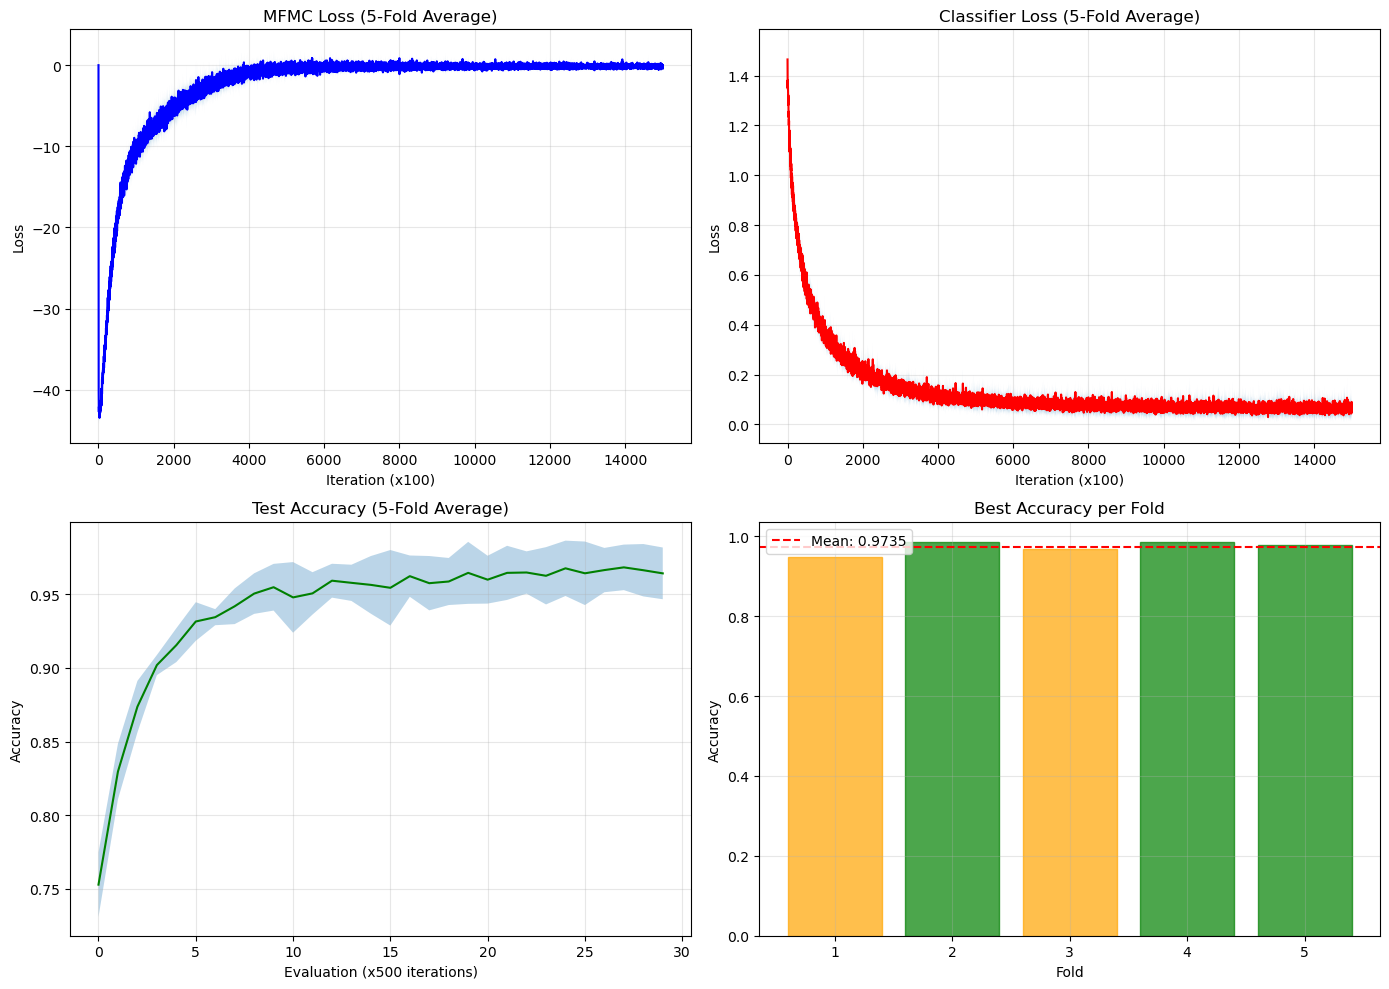

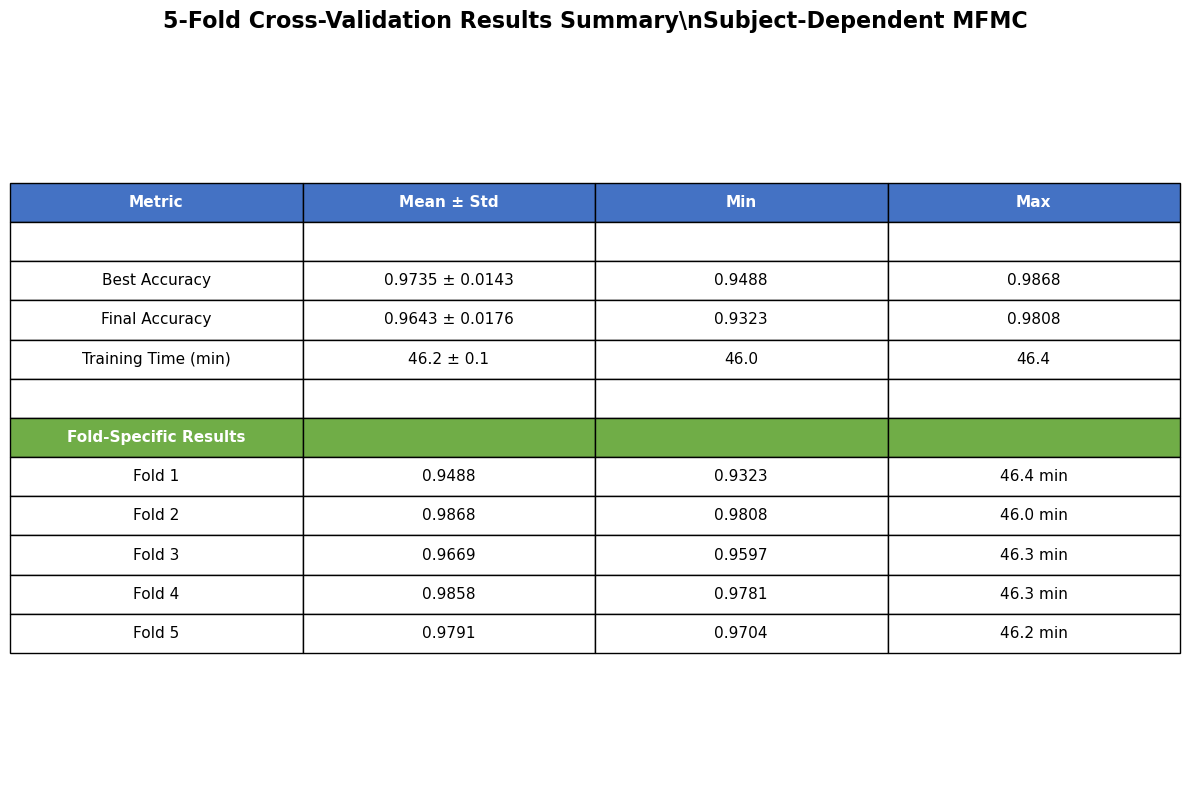

Comprehensive CV results saved to /ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP/MFMC_Demo/results/cv_results.npy
\n======================================================================
SUBJECT-DEPENDENT 5-FOLD CV MFMC DEMO COMPLETE!
FINAL SUMMARY:
Cross-validation completed successfully
Mean best accuracy: 0.9735 ± 0.0143
Mean final accuracy: 0.9643 ± 0.0176
Total training time: 3:51:18
All visualizations and results saved to: /ssdwork/zhengdeyang/AAAI-MM/DEEPDEAP/MFMC_Demo/results
\nGenerated files:
- Individual fold curves: fold_1_curves.png to fold_5_curves.png
- CV summary curves: cv_summary_curves.png
- Results table: cv_results_table.png
- Complete results: cv_results.npy


In [9]:
# =============================================================================
# EVALUATION AND VISUALIZATION
# =============================================================================

def plot_learning_curves(costs, classifier_errors, test_accuracies, save_path, fold=None):
    """Plot training curves for MFMC demo in 2x2 layout"""
    plt.figure(figsize=(14, 10))
    
    # Plot MFMC cost
    plt.subplot(2, 2, 1)
    plt.plot(costs)
    fold_text = f' (Fold {fold})' if fold is not None else ''
    plt.title(f'MFMC Tri-modal Projection Loss{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot classifier error
    plt.subplot(2, 2, 2)
    plt.plot(classifier_errors)
    plt.title(f'Classifier Cross-Entropy Loss{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot test accuracy
    plt.subplot(2, 2, 3)
    plt.plot(test_accuracies)
    plt.title(f'Test Accuracy{fold_text}')
    plt.xlabel(f'Evaluation (x{EVAL_INTERVAL} iterations)')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    # Plot loss comparison
    plt.subplot(2, 2, 4)
    # Normalize losses for comparison
    norm_mfmc = np.array(costs) / (np.max(costs) if len(costs) > 0 and np.max(costs) > 0 else 1)
    norm_classifier = np.array(classifier_errors) / (np.max(classifier_errors) if len(classifier_errors) > 0 and np.max(classifier_errors) > 0 else 1)
    
    plt.plot(norm_mfmc, label='MFMC Loss (normalized)', alpha=0.7)
    plt.plot(norm_classifier, label='Classifier Loss (normalized)', alpha=0.7)
    plt.title(f'Loss Comparison{fold_text}')
    plt.xlabel('Iteration (x100)')
    plt.ylabel('Normalized Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, save_path):
    """Create and display confusion matrix"""
    cm = confusion_matrix(y_true, y_pred)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, ax=ax)
    plt.title('MFMC Confusion Matrix - Emotion Recognition')
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

if data_loaded and 'fold_results' in locals():
    print("Generating 5-fold cross-validation summary and visualizations...")
    print("=" * 70)
    
    # Create average learning curves across all folds
    def plot_cv_summary(all_fold_costs, all_fold_classifier_losses, all_fold_test_accuracies, save_path):
        """Plot average learning curves across all folds in 2x2 layout"""
        plt.figure(figsize=(14, 10))
        
        # Calculate average and std across folds
        max_len_costs = max(len(costs) for costs in all_fold_costs)
        max_len_classifier = max(len(losses) for losses in all_fold_classifier_losses)
        max_len_accuracy = max(len(acc) for acc in all_fold_test_accuracies)
        
        # Pad sequences to same length
        padded_costs = []
        padded_classifier = []
        padded_accuracy = []
        
        for i in range(len(all_fold_costs)):
            costs = all_fold_costs[i] + [all_fold_costs[i][-1]] * (max_len_costs - len(all_fold_costs[i]))
            classifier = all_fold_classifier_losses[i] + [all_fold_classifier_losses[i][-1]] * (max_len_classifier - len(all_fold_classifier_losses[i]))
            accuracy = all_fold_test_accuracies[i] + [all_fold_test_accuracies[i][-1]] * (max_len_accuracy - len(all_fold_test_accuracies[i]))
            
            padded_costs.append(costs)
            padded_classifier.append(classifier)
            padded_accuracy.append(accuracy)
        
        # Convert to numpy arrays
        costs_array = np.array(padded_costs)
        classifier_array = np.array(padded_classifier)
        accuracy_array = np.array(padded_accuracy)
        
        # Calculate means and stds
        costs_mean = np.mean(costs_array, axis=0)
        costs_std = np.std(costs_array, axis=0)
        classifier_mean = np.mean(classifier_array, axis=0)
        classifier_std = np.std(classifier_array, axis=0)
        accuracy_mean = np.mean(accuracy_array, axis=0)
        accuracy_std = np.std(accuracy_array, axis=0)
        
        # Plot MFMC cost with error bars
        plt.subplot(2, 2, 1)
        x_costs = np.arange(len(costs_mean))
        plt.plot(x_costs, costs_mean, 'b-', label='Mean')
        plt.fill_between(x_costs, costs_mean - costs_std, costs_mean + costs_std, alpha=0.3)
        plt.title('MFMC Loss (5-Fold Average)')
        plt.xlabel('Iteration (x100)')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        # Plot classifier loss with error bars
        plt.subplot(2, 2, 2)
        x_classifier = np.arange(len(classifier_mean))
        plt.plot(x_classifier, classifier_mean, 'r-', label='Mean')
        plt.fill_between(x_classifier, classifier_mean - classifier_std, classifier_mean + classifier_std, alpha=0.3)
        plt.title('Classifier Loss (5-Fold Average)')
        plt.xlabel('Iteration (x100)')
        plt.ylabel('Loss')
        plt.grid(True, alpha=0.3)
        
        # Plot test accuracy with error bars
        plt.subplot(2, 2, 3)
        x_accuracy = np.arange(len(accuracy_mean))
        plt.plot(x_accuracy, accuracy_mean, 'g-', label='Mean')
        plt.fill_between(x_accuracy, accuracy_mean - accuracy_std, accuracy_mean + accuracy_std, alpha=0.3)
        plt.title('Test Accuracy (5-Fold Average)')
        plt.xlabel(f'Evaluation (x{EVAL_INTERVAL} iterations)')
        plt.ylabel('Accuracy')
        plt.grid(True, alpha=0.3)
        
        # Plot final accuracy distribution across folds
        plt.subplot(2, 2, 4)
        final_accuracies = [result['best_accuracy'] for result in fold_results]
        fold_numbers = [result['fold'] for result in fold_results]
        
        bars = plt.bar(fold_numbers, final_accuracies, alpha=0.7)
        plt.axhline(y=np.mean(final_accuracies), color='r', linestyle='--', 
                   label=f'Mean: {np.mean(final_accuracies):.4f}')
        plt.title('Best Accuracy per Fold')
        plt.xlabel('Fold')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Color bars based on performance
        for i, bar in enumerate(bars):
            if final_accuracies[i] >= np.mean(final_accuracies):
                bar.set_color('green')
            else:
                bar.set_color('orange')
        
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    # Generate comprehensive summary plot
    plot_cv_summary(all_fold_costs, all_fold_classifier_losses, all_fold_test_accuracies,
                   f'{RESULTS_DIR}/cv_summary_curves.png')
    
    # Create detailed summary table
    def plot_cv_results_table(fold_results, save_path):
        """Create a comprehensive results table"""
        fig, ax = plt.subplots(figsize=(12, 8))
        ax.axis('off')
        
        # Prepare table data
        table_data = [
            ['Metric', 'Mean ± Std', 'Min', 'Max'],
            ['', '', '', '']  # Empty row
        ]
        
        # Calculate statistics
        best_accs = [r['best_accuracy'] for r in fold_results]
        final_accs = [r['final_accuracy'] for r in fold_results] 
        times = [r['training_time'] for r in fold_results]
        
        metrics = [
            ('Best Accuracy', best_accs),
            ('Final Accuracy', final_accs),
            ('Training Time (min)', [t/60 for t in times])
        ]
        
        for metric_name, values in metrics:
            mean_val = np.mean(values)
            std_val = np.std(values)
            min_val = np.min(values)
            max_val = np.max(values)
            
            if 'Time' in metric_name:
                table_data.append([
                    metric_name,
                    f"{mean_val:.1f} ± {std_val:.1f}",
                    f"{min_val:.1f}",
                    f"{max_val:.1f}"
                ])
            else:
                table_data.append([
                    metric_name,
                    f"{mean_val:.4f} ± {std_val:.4f}",
                    f"{min_val:.4f}",
                    f"{max_val:.4f}"
                ])
        
        # Add fold-specific results
        table_data.append(['', '', '', ''])  # Empty row
        table_data.append(['Fold-Specific Results', '', '', ''])
        
        for result in fold_results:
            table_data.append([
                f"Fold {result['fold']}",
                f"{result['best_accuracy']:.4f}",
                f"{result['final_accuracy']:.4f}",
                f"{result['training_time']/60:.1f} min"
            ])
        
        # Create table
        table = ax.table(cellText=table_data, loc='center', cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 2)
        
        # Style header
        for j in range(len(table_data[0])):
            table[(0, j)].set_facecolor('#4472C4')
            table[(0, j)].set_text_props(color='white', weight='bold')
            
        # Style section headers
        for i, row in enumerate(table_data):
            if 'Fold-Specific Results' in row[0]:
                for j in range(len(row)):
                    table[(i, j)].set_facecolor('#70AD47')
                    table[(i, j)].set_text_props(color='white', weight='bold')
        
        plt.title('5-Fold Cross-Validation Results Summary\\nSubject-Dependent MFMC', 
                 pad=20, fontsize=16, weight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()
    
    # Generate results table
    plot_cv_results_table(fold_results, f'{RESULTS_DIR}/cv_results_table.png')
    
    # Save comprehensive results
    cv_results = {
        'cv_statistics': {
            'best_accuracy_mean': cv_mean_best,
            'best_accuracy_std': cv_std_best,
            'final_accuracy_mean': cv_mean_final,
            'final_accuracy_std': cv_std_final,
            'total_cv_time': total_cv_time
        },
        'fold_results': fold_results,
        'all_fold_data': {
            'costs': all_fold_costs,
            'classifier_losses': all_fold_classifier_losses,
            'test_accuracies': all_fold_test_accuracies
        },
        'config': {
            'n_folds': N_FOLDS,
            'batch_size': BATCH_SIZE,
            'total_iterations_per_fold': TOTAL_ITERATIONS,
            'cov_beta': COV_BETA,
            'learning_rate_encoder': LEARNING_RATE_ENCODER,
            'learning_rate_classifier': LEARNING_RATE_CLASSIFIER,
            'use_class_balancing': USE_CLASS_BALANCING,
            'random_seed': RANDOM_SEED
        }
    }
    
    np.save(f'{RESULTS_DIR}/cv_results.npy', cv_results)
    print(f"Comprehensive CV results saved to {RESULTS_DIR}/cv_results.npy")
    
    print("\\n" + "="*70)
    print("SUBJECT-DEPENDENT 5-FOLD CV MFMC DEMO COMPLETE!")
    print("="*70)
    print("FINAL SUMMARY:")
    print(f"Cross-validation completed successfully")
    print(f"Mean best accuracy: {cv_mean_best:.4f} ± {cv_std_best:.4f}")
    print(f"Mean final accuracy: {cv_mean_final:.4f} ± {cv_std_final:.4f}")
    print(f"Total training time: {str(timedelta(seconds=int(total_cv_time)))}")
    print(f"All visualizations and results saved to: {RESULTS_DIR}")
    print("\\nGenerated files:")
    print(f"- Individual fold curves: fold_1_curves.png to fold_{N_FOLDS}_curves.png")
    print(f"- CV summary curves: cv_summary_curves.png")
    print(f"- Results table: cv_results_table.png")
    print(f"- Complete results: cv_results.npy")
    print("="*70)
    
else:
    print("Cannot perform evaluation - cross-validation was not completed or data not loaded")
